# Credit risk scoring project

Decision trees, the simplest tree-based model, are nothing but a sequence of it-then-else rules put together.

We can combine multiple decision trees into an ensemble to achieve better performance. We cover two tree-based ensemble models: random forest and gradient boosting.

The project we prepared for this chapter is default prediction: we predict whether or not a customer will fail to pay back a loan. We learn how to train decision trees and random forest models with Scikit-learn and explore XGBoost-a library for implementing gradient boosting models.

## 6.1. Credit risk scoring project

Imagine that we work at a bank. When we receive a loan application, we need to make sure that if we give the money, the customer will be able to pay it back. Every application carries a risk of default—the failure to return the money.

We’d like to minimize this risk: before agreeing to give a loan, we want to score the customer and assess the chances of default. If it’s too high, we reject the application. This process is called “credit risk scoring.”

In this chapter we will use machine learning to calculate the risk of default. The plan for the project is the following:

- First, we get the data and do some initial preprocessing.
- Next, we train a decision tree model from Scikit-learn for predicting the probability of default.
- After that, we explain how decision trees work and which parameters the model has and show how to adjust these parameters to get the best performance.
- Then we combine multiple decision trees into one model—a random forest. We look at its parameters and tune them to achieve the best predictive performance.
- Finally, we explore a different way of combining decision trees—gradient boosting. We use XGBoost, a highly efficient library that implements gradient boosting. We’ll train a model and tune its parameters.

Credit risk scoring is a binary classification problem: the target is positive (“1”) if the customer defaults and negative (“0”) otherwise. For evaluating our solution, we’ll use AUC (area under the ROC curve), which we covered in chapter 4. AUC describes how well our model can separate the cases into positive and negative ones.

### 6.1.1. Credit scoring dataset

In [2]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("CreditScoring.csv")

### 6.1.2. Data cleaning

In [5]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


For some columns, "1" means "OK", "2" means "default", and "0" means the value is missing, let's replace it with "unk" (short for "unknown").

In Pandas, we can use map for converting the numbers to strings. For that, we first define the dictionary with mapping from the current value (number) to the desired value (string):

In [7]:
status_values = {
    1: "ok",
    2: "default",
    0: "unk"
}

Now we can use this dictionary to do the mapping:

In [8]:
df["status"] = df["status"].map(status_values)

We repeat the same procedure for all the other columns.

In [9]:
home_values = {
    1: "rent",
    2: "owner",
    3: "private",
    4: "ignore",
    5: "parents",
    6: "other",
    0: "unk"
}

df["home"] = df["home"].map(home_values)

In [10]:
marital_values = {
    1: "single",
    2: "married",
    3: "widow",
    4: "separated",
    5: "divorced",
    0: "unk"
}
 
df["marital"] = df["marital"].map(marital_values)

In [11]:
records_values = {
    1: "no",
    2: "yes",
    0: "unk"
}
 
df["records"] = df["records"].map(records_values)

After these transformations, the columns with categorical variables contain the actual values, not numbers.

In [12]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,3,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,1,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,3,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,1,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,1,46,107,0,0,310,910


Next, let's look at the numerical columns. First, let's check the summary statistics for each of the columns: min, mean, max, and others.

In [13]:
df.describe().round()

,seniority,time,age,job,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,2.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,1.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,0.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,1.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,1.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,3.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,4.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


One thing we notice immediately is that the max value is 99999999 in some cases. This is quite suspicious. As it turns out, it’s an artificial value—this is how missing values are encoded in this dataset.

Three columns have this problem: income, assets, and debt. Let’s replace this big number with NaN for these columns:

In [14]:
for column in ["income", "assets", "debt"]:
    df[column] = df[column].replace(to_replace=99999999, value=np.nan)

In [15]:
df.describe().round()

,seniority,time,age,job,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,2.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,1.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,0.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,1.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,1.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,3.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,4.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [16]:
df["status"].value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

Let's get rid of the row with "unk" as its status.

In [17]:
df = df[df["status"] != "unk"]

### 6.1.3. Dataset preparation

Now our dataset is cleaned, and we’re almost ready to use it for model training. Before we can do that, we need to do a few more steps:

- Split the dataset into train, validation, and test.
- Handle missing values.
- Use one-hot encoding to encode categorical variables.
- Create the feature matrix X and the target variable y.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [20]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

The outcome we want to predict is status. We will use it to train a model, so it's our y-the target variable. The target variable is "1" if the client defaulted and "0" otherwise.

In [21]:
y_train = (df_train["status"] == "default").values
y_val = (df_val["status"] == "default").values

del df_train["status"]
del df_val["status"]

X is the feature matrix.

From the initial analysis, we know our data contains missing values—we added these NaNs ourselves. We can replace the missing values with zero:

In [22]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

To use categorical variables, we need to encode them. We will use one-hot encoding, and implement it using DictVectorizer. DictVectorizer needs a list of dictionaries, so we first need to convert the DataFrame:

In [23]:
dict_train = df_train.to_dict(orient="records")
dict_val = df_val.to_dict(orient="records")

In [24]:
dict_train[0]

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 3,
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

Now we can use the list of dictionaries with DictVectorizer:

In [25]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

As a result, we have feature matrices for both train and validation datasets.

## 6.2. Decision trees

A decision tree is a data structure that encodes a series of if-then-else rules. Each node in a tree contains a condition. If the condition is satisfied, we go to the right side of the tree; otherwise, we go to the left. In the end we arrive at the final decision.

It's quite easy to represent a decisioin tree as a set of if-else statements in Python. For example:

In [26]:
def assess_risk(client):
    if client["records"] == "yes":
        if client["job"] == "parttime":
            return "default"
        else:
            return "ok"
    else:
        if client["assets"] < 4000:
            return "ok"
        else:
            return "default"

With machine learning, we can extract these rules from data automatically. Let’s see how we can do it.

### 6.2.1. Decision tree classifier

In [27]:
from sklearn.tree import DecisionTreeClassifier

Training the model is as simple as invoking the fit model:

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

To check if the result is good, we need to evaluate the predictive performance of the model on the validation set. Let's use AUC for that. Credit risk scoring is a binary classification problem, and for cases like that, AUC is one of the best evaluation metrics. AUC describes the probability that a randomly chosen positive example ("default") has a higher score than a randomly chosen negative example ("OK").

In [29]:
from sklearn.metrics import roc_auc_score

First, we evaluate the performance on the training set. Because we chose AUC as the evaluation metric, we need scores, not hard predictions. As we know, we need to use  method for that:

In [30]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

np.float64(1.0)

When we execute it, we see that the score is 100%—the perfect score. Does it mean that we can predict default without errors? Let’s check the score on validation before jumping to conclusions:

In [31]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.6656293138940689)

That's a case of overfitting - our model on the training data performs perfectly, but fails on validation. The tree learned the training data so well that it simply memorized the outcome for each customer. However, when we applied it to the validation set, the model failed. The rules it extracted from the data turned out to be too specific to the training set, so it worked poorly for customers it didn't see during training. In such cases, we say that the model cannot generalize.

We have multiple ways to control the complexity of a tree. One option is to restrict its size: we can specify the max_depth parameter, which controls the maximum number of levels. The more levels a tree has, the more complex rules it can learn.

The default value for the max_depth parameter is None, which means that the tree can grow as large as possible. We can try a smaller value and compare the results.

In [32]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

To visualize the tree we just learned, we can use the export_text function from the tree package:

In [33]:
from sklearn.tree import export_text

tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False
|--- records=no >  0.50
|   |--- seniority <= 2.50
|   |   |--- class: False
|   |--- seniority >  2.50
|   |   |--- class: False



The condition records=no > 0.50 means that a customer has no records. For a customer with no records, records=no is set to "1" and records=yes to "0". Thus, records=no > 0.50 is true when the value for records is no.

Let's check the score:

In [34]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print("train auc", auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print("validation auc", auc)

train auc 0.7274153568813024
validation auc 0.6894934731539561


The score on train dropped, it means that the model can no longer memorize all the outcomes from the training set. The score on the validation set is better. By making the model less complex, we improved the ability of our model to generalize. Now it's better at predicting the outcomes for customers it hasn't seen previously.

However, this tree has another problem - it's too simple. To make it better, we need to tune the model: try different parameters, and see which ones lead to the best AUC. In addition to max_depth, we can control other parameters. To understand what these parameters mean and how they influence the model, let's take a step back and look at how decision trees learn rules from data.

### 6.2.2. Decision tree learning algorithm

Groups in a decision tree should be as homogenous as possible. Ideally, each group should contain only observations of one class. For example, if we have a group of four customers with outcomes [“default,” “default,” “default,” “default”], it’s pure: it contains only customers who defaulted. But a group [“default,” “default,” “default,” “OK”] is impure: there’s one customer who didn’t default.

When training a decision tree mode, we want to find such T (a threshold used in a decision tree) tha the impurity of both groups is minimal. The algorithm for finding T tries all possible values of T, for each T splits the dataset into left and right groups and measures their impurity, and then selectes the T that has the lowest degree of impurity.

We can use different criteria for measuring impurity. The easiest one to understand is the misclassification rate, which says how many observations in a group don't belong to the majority class.

If there is a group and the majority class is "default", if there are four data points in total, and one doesn't belong to "default", the misclassification rate is 25%. To calculate the overall impurity of the split, we can take the average across both groups.

When training a decision tree, if you don't put any restrictions on the trees in Scikit-learn, the data keeps splitting until all of the groups are pure. This results in a model that becomes too complex, which leads to overfitting. This can be solved by using the max_depth parameter, so that the tree doesn't grow too large.

To decide if we want to continue splitting the data, we use stopping criteria - criteria that describes if we should add another split in the tree or stop.

The most common stopping criteria are:

- The group is already pure.
- The tree reached the depth limit (controlled by the max_depth parameter).
- The group is too small to continue splitting (controlled by the max_samples_leaf parameter).

By using these criteria to stop earlier, we force our model to be less complex and, therefore, reduce the risk of overfitting.

Let's use this information to adjust the training algorithm:

- Find the best split:
    - For each feature try all possible threshold values.
    - Usew the one with the lowest impurity.
- If the maximum allowed depth is reached, stop.
- If the group on the left is sufficiently large and it's not pure yet, repeat on the left.
- If the group on the right is sufficiently large and it's not pure yet, repeat on the right.

Even though this is a simplified version of the decision tree learning algorithm, it should provide you enough intuition about the internals of the learning process.

### 6.2.3. Parameter tuning for decision tree

The process of finding the best set of parameters is called parameter tuning. We usually do it by changing the model and checking its score on the validation dataset. In the end, we use the model with the best validation score.

We can tune two parameters:

- max_depth
- min_leaf_size

These two are the most important ones, so we will adjust only them. Scikit-learn has other parameters that we can use in the future.

For tuning max_depth, we iterate over a few reasonable values and see what works best:

In [35]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print("%4s -> %.3f" % (depth, auc))

   1 -> 0.606
   2 -> 0.689
   3 -> 0.742
   4 -> 0.747
   5 -> 0.746
   6 -> 0.740
  10 -> 0.669
  15 -> 0.658
  20 -> 0.665
None -> 0.653


When we run this code, we see that max_depth of 4 gives the best AUC (74.7%), followed by 5 and then 3.

Next, we tune min_leaf_size. For that, we iterate over the three best parameters of max_depth, and for each, go over different values of min_leaf_size:

In [36]:
for m in [4, 5, 6]:
    print("depth: %s" % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print("%s -> %.3f" % (s, auc))

depth: 4
1 -> 0.747
5 -> 0.747
10 -> 0.747
15 -> 0.750
20 -> 0.750
50 -> 0.745
100 -> 0.748
200 -> 0.738
depth: 5
1 -> 0.746
5 -> 0.748
10 -> 0.747
15 -> 0.756
20 -> 0.760
50 -> 0.764
100 -> 0.766
200 -> 0.745
depth: 6
1 -> 0.738
5 -> 0.747
10 -> 0.758
15 -> 0.765
20 -> 0.776
50 -> 0.784
100 -> 0.774
200 -> 0.749


We see that the best AUC is 78.4% with parameters min_samples_leaf=50 and max_depth=6.

We have found the best parameters, so let's use them to train the final model:

In [37]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=50)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=50)

Decision trees are simple and effective models, but they become even more powerful when we combine many trees together. Next, we'll see how we can do it to achieve even better predictive performance.

## 6.3. Random forest

One model individually may be wrong, but if we combine the output of multiple models into one, the chance of an incorrect answer is smaller. This concept is calld ensemble learning, and a combination of models is called an ensemble.

For this to work, the models need to be different. If we train the same decision tree model 10 times, they will all predict the same output, so it's not useful at all.

The easiest way to have different models is to train each tree on a different subset of features. For example, suppose we have three features: assets, debts, and price. We can train three models:

- The first will use assets and debts.
- The second will use debts and price.
- The last one will use assets and price.

With this approach, we’ll have different trees, each making its own decisions. But when we put their predictions together, their mistakes average out, and combined, they have more predictive power.

This way of putting together multiple decision trees into an ensemble is called a random forest. To train a random forest, we can do this:

- Train N independent decision tree models.
- For each model, select a random subset of features, and use only them for training.
- When predicting, combine the output of N models into one.

This is a very simplified version of the algorithm. It's enough to illustrate the main idea, but in reality, it's more complex.

Scikit-learn contains an implementation of a random forest, so we can use it for solving our problem. Let's do it.

### 6.3.1. Training a random forest

To use random forest in Scikit-learn, we need to import RandomForestClassifier from the ensemble package:

In [38]:
from sklearn.ensemble import RandomForestClassifier

When training a model, the first thing we need to specify is the number of trees we want to have in the ensemble. We do it with the n_estimators parameter:

In [39]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

After training finishes, we can evaluate the performance of the result:

In [40]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.78885229226708)

It shows 79.5%. However, the number you see may be different. Every time we retrain the model, the score changes: it varies from 77% to 80%.

The reason for this is randomization: to train a tree, we randomly select a subset of features. To make the results consistent, we need to fix the seed for the random-number generator by assigning some value to the random_state parameter:

In [41]:
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=3)

In [42]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.7884284710953962)

This time, we get an AUC of 78.8%. This score doesn’t change, no matter how many times we retrain the model.

The number of trees in the ensemble is an important parameter, and it influences the performance of the model. Usually, a model with more trees is better than a model with fewer trees. On the other hand, adding too many trees is not always helpful.

To see how many trees we need, we can iterate over different values for n_estimators and see its effect on AUC:

In [43]:
aucs = []

for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print("%s -> %.3f" % (i, auc))

    aucs.append(auc)

10 -> 0.788
20 -> 0.813
30 -> 0.815
40 -> 0.813
50 -> 0.814
60 -> 0.814
70 -> 0.813
80 -> 0.816
90 -> 0.816
100 -> 0.817
110 -> 0.818
120 -> 0.819
130 -> 0.819
140 -> 0.819
150 -> 0.820
160 -> 0.820
170 -> 0.820
180 -> 0.819
190 -> 0.819
200 -> 0.819


Let's plot the results:

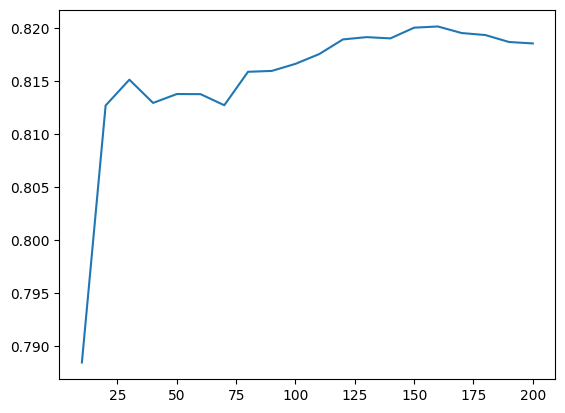

In [44]:
plt.plot(range(10, 201, 10), aucs)

The performance grows rapidly for the first 25-30 trees; then the growth slows down. After 150, adding more trees is not helpful anymore: the performance stays approximately at the level of 82%.

The number of trees is not the only parameter we can change to get better performance. Next, we see which other parameters we should also tune to improve the model.

### 6.3.2. Parameter runing for random forest

A random forest ensemble consists of multiple decision trees, so the most important parameters we need to tune for random forest are the same:

- max_depth
- min_leaf_size

We can change other parameters in the future.

Let's start with max_depth. We already know that this parameter significantly affects the performance of a decision tree. This is also the case for random forest: larger trees tend to overfit more than smaller trees.

In [45]:
all_aucs = {}

for depth in [5, 10, 20]:
    print("depth: %s" % depth)
    aucs = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print("%s -> %.3f" % (i, auc))
        aucs.append(auc)

    all_aucs[depth] = aucs
    print()

depth: 5
10 -> 0.795
20 -> 0.798
30 -> 0.796
40 -> 0.797
50 -> 0.797
60 -> 0.800
70 -> 0.801
80 -> 0.802
90 -> 0.802
100 -> 0.803
110 -> 0.806
120 -> 0.807
130 -> 0.807
140 -> 0.806
150 -> 0.806
160 -> 0.806
170 -> 0.806
180 -> 0.806
190 -> 0.806
200 -> 0.806

depth: 10
10 -> 0.809
20 -> 0.814
30 -> 0.819
40 -> 0.823
50 -> 0.821
60 -> 0.819
70 -> 0.820
80 -> 0.819
90 -> 0.820
100 -> 0.821
110 -> 0.822
120 -> 0.821
130 -> 0.821
140 -> 0.820
150 -> 0.820
160 -> 0.819
170 -> 0.821
180 -> 0.821
190 -> 0.822
200 -> 0.822

depth: 20
10 -> 0.773
20 -> 0.792
30 -> 0.798
40 -> 0.810
50 -> 0.813
60 -> 0.816
70 -> 0.818
80 -> 0.818
90 -> 0.818
100 -> 0.819
110 -> 0.820
120 -> 0.820
130 -> 0.820
140 -> 0.819
150 -> 0.819
160 -> 0.818
170 -> 0.818
180 -> 0.818
190 -> 0.818
200 -> 0.819



Now, let's plot them:

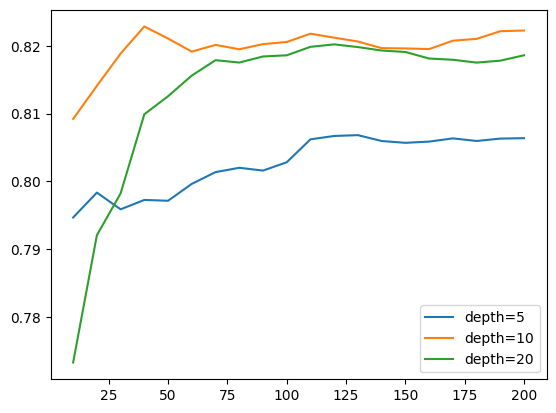

In [46]:
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label="depth=5")
plt.plot(num_trees, all_aucs[10], label="depth=10")
plt.plot(num_trees, all_aucs[20], label="depth=20")
plt.legend()

With max_depth=10, AUC goes over 82%, whereas for other values it performs worse.

Now let’s tune min_samples_leaf. We set the value for the max_depth parameter from the previous step and then follow the same approach as previously for determining the best value for min_samples_leaf:

In [47]:
all_aucs = {}

for m in [3, 5, 10]:
    print("min_samples_leaf: %s" % m)
    aucs = []

    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print("%s ->> %.3f" % (i, auc))
        aucs.append(auc)

    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 ->> 0.805
30 ->> 0.815
50 ->> 0.816
70 ->> 0.819
90 ->> 0.819
110 ->> 0.821
130 ->> 0.822
150 ->> 0.821
170 ->> 0.822
190 ->> 0.822

min_samples_leaf: 5
10 ->> 0.805
30 ->> 0.814
50 ->> 0.815
70 ->> 0.817
90 ->> 0.817
110 ->> 0.818
130 ->> 0.819
150 ->> 0.819
170 ->> 0.819
190 ->> 0.819

min_samples_leaf: 10
10 ->> 0.799
30 ->> 0.811
50 ->> 0.815
70 ->> 0.815
90 ->> 0.815
110 ->> 0.818
130 ->> 0.819
150 ->> 0.819
170 ->> 0.819
190 ->> 0.819



Time to plot it:

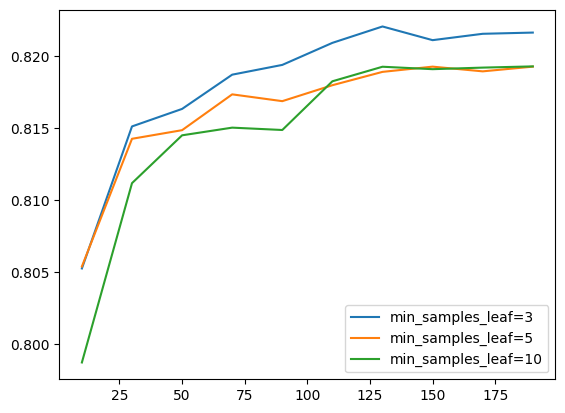

In [48]:
num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label="min_samples_leaf=3")
plt.plot(num_trees, all_aucs[5], label="min_samples_leaf=5")
plt.plot(num_trees, all_aucs[10], label="min_samples_leaf=10")
plt.legend()

We see that AUC is slightly better for small values of min_samples_leaf and the best value is 3.

Thus, the best parameters for random forest for our problem are:

- max_depth=10
- min_samples_leaf=3

We achieved the best AUC with 125 trees, so we should set the n_estimators parameter to 125.

Let's train the final model:

In [49]:
rf = RandomForestClassifier(n_estimators=125, max_depth=10, min_samples_leaf=3, random_state=1)

Random forest is not the only way to combine multiple decision trees. There’s a different approach: gradient boosting. We cover that next.

## 6.4. Gradient boosting

In a random forest, each tree is independent: it's trained on a different set of features. After individual trees are trained, we combine all their decisions together to get the final decision.

It's not the only way to combine multiple models together in one ensemble, however. Alternatively, we can train models sequentially - each next model tries to fix errors from the previous one:

- Train the first model.
- Look at the errors it makes.
- Train another model that fixes these errors.
- Look at the errors again; repeat sequentially.

This way of combining models is called boosting. Gradient boosting is a particular variation of this approach that works especially wrell with trees.

### 6.4.1. XGBoost: Extreme gradient boosting

We have many good implementations of the gradient boosting model: GradientBoostingClassifier from Scikit-learn, XGBoost, LightGBM and CatBoost. In this chapter, we use XGBoost (short for “Extreme Gradient Boosting”), which is the most popular implementation.

In [61]:
import xgboost as xgb

# so you don't get any lame warnings
xgb.set_config(verbosity=0)

Using the alias xgb when importing XGBoost is a convention, just like with other popular machine learning packages in Python.

Before we can train an XGBoost model, we need to wrap our data into DMatrix—a special data structure for finding splits efficiently. Let’s do it:

In [55]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)

When creating an instance of DMatrix, we pass three parameters:

- X_train: the feature matrix
- y_train: the target variable
- feature_names: the names of features in X_train

Let's do the same for the validation dataset:

In [56]:
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

The next step is specifying the parameters for training. We're using only a small subset of the default parameters of XGBoost (check the official documentation for the entire list of parameters)

In [57]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,

    "objective": "binary:logistic",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

For us, the most important parameter now is objective: it specifies the learning task. We’re solving a binary classification problem - that's why we need to choose binary:logistic. We cover the rest of these parameters later.

For training an XGBoost model, we use the train function. Let’s start with 10 trees:

In [63]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

We provide three arguments to train:

- xgb_params: the parameters for training
- dtrain: the dataset for training (an instance of DMatrix)
- num_boost_round=10: the number of trees to train

To evaluate the model, we need to make a prediction on the validation dataset. For that, use the predict method with the validation data wrapped in DMatrix:

In [64]:
y_pred = model.predict(dval)

The result, y_pred, is a one-dimensional NumPy array with predictions; the risk score for each customer in the validation dataset.

Next, we calculate AUC using the same approach as previously:

In [71]:
roc_auc_score(y_val, y_pred)

np.float64(0.8156105446707516)

After executing it, we get 81.6%. This is quite a good result, but it’s still slightly worse than our best random forest model (82%).

Training an XGBoost model is simpler when we can see how its perfoemance changes when the number of trees grows.

### 6.4.2. Model performance monitoring

To get an idea of how AUC changes as the number of trees grows, we can use a watchlist - a built-in feature in XGBoost for monitoring model performance.

A watchlist is a Python list with tuples. Each tuple contains a DMatrix and its name. This is how we typically do it:

In [72]:
watchlist = [(dtrain, "train"), (dval, "val")]

Additionally, we modify the list of parameters for training: we need to specify the metric we use for evaluation. In our case, it's the AUC:

In [91]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,

    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

To use the watchlist during training, we need to specify two extra arguments for the train function:

- evals: the watchlist.
- verbose_eval: how often we print the metric. If we set it to “10,” we see the result after each 10th step.

Let’s train it:

In [92]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.86806	val-auc:0.78152
[10]	train-auc:0.95369	val-auc:0.81754
[20]	train-auc:0.97458	val-auc:0.82619
[30]	train-auc:0.98739	val-auc:0.81783
[40]	train-auc:0.99414	val-auc:0.81504
[50]	train-auc:0.99761	val-auc:0.81283
[60]	train-auc:0.99895	val-auc:0.81239
[70]	train-auc:0.99970	val-auc:0.81270
[80]	train-auc:0.99992	val-auc:0.80947
[90]	train-auc:0.99996	val-auc:0.81002
[99]	train-auc:1.00000	val-auc:0.81022


As the number of trees grows, the score on the training set goes up. This behavior is expected: in boosting, every next model tries to fix the mistakes from the previous step, so the score is always improving.

For the validation score, however, this is not the case. It goes up initially but then starts to decrease. This is the effect of overfitting: our model becomes more and more complex until it simply memorizes the entire training set. It’s not helpful for predicting the outcome for the customers outside of the training set, and the validation score reflects that.

We get the best AUC on the 20th iteration (82.6%), but it’s not so different from the score we got on the 10th iteration (82%).

Next, we’ll see how to get the best out of XGBoost by tuning its parameters.

### 6.4.3. Parameter tuning for XGBoost

Previously, we used a subset of default parameters for training a model:

In [93]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

We’re mostly interested in the first three parameters. These parameters control the training process:

- eta: Learning rate. Decision trees and random forest don’t have this parameter. We cover it later in this section when we tune it.
- max_depth: The maximum allowed depth of each tree; the same as max_depth in DecisionTreeClassifier from Scikit-learn.
- min_child_weight: The minimal number of observations in each group; the same as min_leaf_size in DecisionTreeClassifier from Scikit-learn.

Other parameters:

- objective: The type of task we want to solve. For classification, it should be binary:logistic.
- eval_metric: The metric we use for evaluation. For this project, it’s “AUC.”
- nthread: The number of threads we use for training the model. XGBoost is very good at parallelizing training, so set it to the number of cores your computer has.
- seed: The seed for the random-number generator; we need to set it to make sure the results are reproducible.
- silent: The verbosity of the output. When we set it to “1,” it outputs only warnings.

This is not the full list fo parameters, only the basic ones.

We already know max_depth and min_child_weight (min_leaf_size), but we haven't previously come across eta—the learning rate parameter. Let’s talk about it and see how we can optimize it.

In boosting, each tree tries to correct the mistakes from the previouss iterations. Learning rate determines the weight of this correction. If we have a large value for eta, the correction overwights the previous perdictions significantly. On the other hand, if the value is small, only a small fraction of this correction is used.

In practice it means

- If eta is too large, the model starts to overfit quite early without realizing its full potential.
- If it’s too small, we need to train too many trees before it can produce good results.

The default value of 0.3 is reasonably good for large datasets, but for smaller datasets like ours, we should try smaller values like 0.1 or even 0.05.

In [94]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

Because now we can use a watchlist to monitor the performance of our model, we can train for as many iterations as we want. Previously we used 100 iterations, but this may be not enough for smaller eta. So let’s use 500 rounds for training:

In [95]:
model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.86806	val-auc:0.78152
[10]	train-auc:0.91907	val-auc:0.80505
[20]	train-auc:0.94196	val-auc:0.81324
[30]	train-auc:0.95600	val-auc:0.81574
[40]	train-auc:0.96511	val-auc:0.81904
[50]	train-auc:0.97038	val-auc:0.82097
[60]	train-auc:0.97676	val-auc:0.82096
[70]	train-auc:0.98149	val-auc:0.82013
[80]	train-auc:0.98546	val-auc:0.81845
[90]	train-auc:0.98810	val-auc:0.81809
[100]	train-auc:0.98963	val-auc:0.81779
[110]	train-auc:0.99156	val-auc:0.81777
[120]	train-auc:0.99387	val-auc:0.81619
[130]	train-auc:0.99545	val-auc:0.81568
[140]	train-auc:0.99636	val-auc:0.81534
[150]	train-auc:0.99728	val-auc:0.81505
[160]	train-auc:0.99795	val-auc:0.81536
[170]	train-auc:0.99840	val-auc:0.81431
[180]	train-auc:0.99874	val-auc:0.81338
[190]	train-auc:0.99903	val-auc:0.81389
[200]	train-auc:0.99930	val-auc:0.81313
[210]	train-auc:0.99941	val-auc:0.81135
[220]	train-auc:0.99955	val-auc:0.81029
[230]	train-auc:0.99962	val-auc:0.80943
[240]	train-auc:0.99975	val-auc:0.80877
[250]	train

When running it, we see that the best validation score is 82.1%.

When eta is 0.3, we get the best AUC pretty quickly, but then it starts to overfit. After the 10th iteration, the performance on the validation set goes down.

When eta is 0.1, AUC grows more slowly but peaks at a higher value. For a smaller learning rate, it takes more trees to reach the peak, but we could achieve better performance.

Let's try other values of eta:

In [96]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.86806	val-auc:0.78152
[10]	train-auc:0.90258	val-auc:0.79371
[20]	train-auc:0.91793	val-auc:0.80157
[30]	train-auc:0.93106	val-auc:0.80991
[40]	train-auc:0.94148	val-auc:0.81567
[50]	train-auc:0.94851	val-auc:0.81867
[60]	train-auc:0.95566	val-auc:0.82004
[70]	train-auc:0.95960	val-auc:0.82104
[80]	train-auc:0.96296	val-auc:0.82247
[90]	train-auc:0.96662	val-auc:0.82318
[100]	train-auc:0.97049	val-auc:0.82458
[110]	train-auc:0.97361	val-auc:0.82580
[120]	train-auc:0.97632	val-auc:0.82537
[130]	train-auc:0.97894	val-auc:0.82626
[140]	train-auc:0.98049	val-auc:0.82600
[150]	train-auc:0.98229	val-auc:0.82542
[160]	train-auc:0.98404	val-auc:0.82527
[170]	train-auc:0.98556	val-auc:0.82547
[180]	train-auc:0.98693	val-auc:0.82477
[190]	train-auc:0.98832	val-auc:0.82455
[200]	train-auc:0.98950	val-auc:0.82409
[210]	train-auc:0.99046	val-auc:0.82323
[220]	train-auc:0.99136	val-auc:0.82257
[230]	train-auc:0.99234	val-auc:0.82190
[240]	train-auc:0.99321	val-auc:0.82284
[250]	train

In [97]:
xgb_params = {
    "eta": 0.01,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.86806	val-auc:0.78152
[10]	train-auc:0.87829	val-auc:0.78131
[20]	train-auc:0.89194	val-auc:0.79182
[30]	train-auc:0.89651	val-auc:0.79455
[40]	train-auc:0.89858	val-auc:0.79276
[50]	train-auc:0.90178	val-auc:0.79188
[60]	train-auc:0.90516	val-auc:0.79478
[70]	train-auc:0.90824	val-auc:0.79639
[80]	train-auc:0.91112	val-auc:0.79807
[90]	train-auc:0.91485	val-auc:0.80087
[100]	train-auc:0.91763	val-auc:0.80297
[110]	train-auc:0.91991	val-auc:0.80475
[120]	train-auc:0.92256	val-auc:0.80630
[130]	train-auc:0.92571	val-auc:0.80785
[140]	train-auc:0.92808	val-auc:0.80877
[150]	train-auc:0.93035	val-auc:0.80985
[160]	train-auc:0.93265	val-auc:0.81069
[170]	train-auc:0.93509	val-auc:0.81195
[180]	train-auc:0.93708	val-auc:0.81319
[190]	train-auc:0.93870	val-auc:0.81418
[200]	train-auc:0.94022	val-auc:0.81528
[210]	train-auc:0.94182	val-auc:0.81662
[220]	train-auc:0.94339	val-auc:0.81758
[230]	train-auc:0.94478	val-auc:0.81858
[240]	train-auc:0.94619	val-auc:0.81935
[250]	train

We see that:

- for 0.05, the best AUC is 82.6% after 130 iterations
- for 0.01, the best AUC is 82.5% after 500 iterations

When eta is 0.05, the performance is similar to 0.1, but it takes 80 more iterations to reach the peak.

For eta of 0.01, it grows too slowly, and even after 500 iterations, it hasn’t reached the peak. If we tried it for more iterations, it could potentially get to the same level of AUC as other values. Even if it was the case, it’s not practical: it becomes computationally expensive to evaluate all these trees during prediction time.

Thus, we use the value of 0.1 for eta. Next, let’s tune other parameters.

The next parameter we tune is max_depth. The default value is 6, so we can try

- A lower value; for example, 3
- A higher value; for example, 10

The outcome should give us an idea if the best value for max_depth is between 3 and 6 or between 6 and 10.

In [98]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.77984	val-auc:0.74478
[10]	train-auc:0.84360	val-auc:0.78265
[20]	train-auc:0.86704	val-auc:0.80600
[30]	train-auc:0.87991	val-auc:0.81322
[40]	train-auc:0.88763	val-auc:0.81792
[50]	train-auc:0.89458	val-auc:0.82131
[60]	train-auc:0.90192	val-auc:0.82435
[70]	train-auc:0.90661	val-auc:0.82759
[80]	train-auc:0.91098	val-auc:0.82982
[90]	train-auc:0.91480	val-auc:0.82958
[100]	train-auc:0.91824	val-auc:0.83086
[110]	train-auc:0.92114	val-auc:0.83179
[120]	train-auc:0.92412	val-auc:0.83207
[130]	train-auc:0.92619	val-auc:0.83233
[140]	train-auc:0.92850	val-auc:0.83240
[150]	train-auc:0.93120	val-auc:0.83311
[160]	train-auc:0.93289	val-auc:0.83268
[170]	train-auc:0.93475	val-auc:0.83291
[180]	train-auc:0.93710	val-auc:0.83303
[190]	train-auc:0.93853	val-auc:0.83302
[200]	train-auc:0.94026	val-auc:0.83253
[210]	train-auc:0.94193	val-auc:0.83241
[220]	train-auc:0.94383	val-auc:0.83192
[230]	train-auc:0.94585	val-auc:0.83169
[240]	train-auc:0.94718	val-auc:0.83175
[250]	train

The best AUC we get with it is 83.3%.

In [99]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 10,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.93058	val-auc:0.77472
[10]	train-auc:0.98032	val-auc:0.79235
[20]	train-auc:0.99385	val-auc:0.79908
[30]	train-auc:0.99779	val-auc:0.80082
[40]	train-auc:0.99939	val-auc:0.80397
[50]	train-auc:0.99977	val-auc:0.80647
[60]	train-auc:0.99989	val-auc:0.80822
[70]	train-auc:0.99996	val-auc:0.80753
[80]	train-auc:0.99999	val-auc:0.80803
[90]	train-auc:1.00000	val-auc:0.80857
[100]	train-auc:1.00000	val-auc:0.80801
[110]	train-auc:1.00000	val-auc:0.80671
[120]	train-auc:1.00000	val-auc:0.80733
[130]	train-auc:1.00000	val-auc:0.80667
[140]	train-auc:1.00000	val-auc:0.80621
[150]	train-auc:1.00000	val-auc:0.80517
[160]	train-auc:1.00000	val-auc:0.80514
[170]	train-auc:1.00000	val-auc:0.80455
[180]	train-auc:1.00000	val-auc:0.80442
[190]	train-auc:1.00000	val-auc:0.80432
[200]	train-auc:1.00000	val-auc:0.80476
[210]	train-auc:1.00000	val-auc:0.80502
[220]	train-auc:1.00000	val-auc:0.80494
[230]	train-auc:1.00000	val-auc:0.80500
[240]	train-auc:1.00000	val-auc:0.80465
[250]	train

When max_depth is 10, the best AUC value is 80.9%

This means that the optimal parameter of max_depth should be between 3 and 6.

In [100]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 4,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.81479	val-auc:0.74083
[10]	train-auc:0.86215	val-auc:0.79606
[20]	train-auc:0.88759	val-auc:0.81257
[30]	train-auc:0.90331	val-auc:0.81966
[40]	train-auc:0.91223	val-auc:0.82194
[50]	train-auc:0.92000	val-auc:0.82474
[60]	train-auc:0.92706	val-auc:0.82601
[70]	train-auc:0.93255	val-auc:0.82725
[80]	train-auc:0.93781	val-auc:0.82790
[90]	train-auc:0.94188	val-auc:0.82741
[100]	train-auc:0.94643	val-auc:0.82803
[110]	train-auc:0.95033	val-auc:0.82746
[120]	train-auc:0.95354	val-auc:0.82661
[130]	train-auc:0.95707	val-auc:0.82745
[140]	train-auc:0.95933	val-auc:0.82744
[150]	train-auc:0.96133	val-auc:0.82655
[160]	train-auc:0.96372	val-auc:0.82489
[170]	train-auc:0.96630	val-auc:0.82403
[180]	train-auc:0.96843	val-auc:0.82410
[190]	train-auc:0.96988	val-auc:0.82372
[200]	train-auc:0.97155	val-auc:0.82374
[210]	train-auc:0.97361	val-auc:0.82388
[220]	train-auc:0.97581	val-auc:0.82330
[230]	train-auc:0.97728	val-auc:0.82315
[240]	train-auc:0.97857	val-auc:0.82237
[250]	train

When we try 4, however, we see that the best AUC is 82.8%, which is slightly worse than the AUC we got with the depth of 3.

The next parameter we tune is min_child_weight. It’s the same as min_leaf_size in decision trees from Scikit-learn: it controls the minimal number of observations a tree can have in a leaf.

Let’s try a range of values and see which one works best. In addition to the default value (1), we can try 10 and 30.

In [101]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 10,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.77984	val-auc:0.74478
[10]	train-auc:0.84395	val-auc:0.78407
[20]	train-auc:0.86519	val-auc:0.80736
[30]	train-auc:0.87698	val-auc:0.81511
[40]	train-auc:0.88277	val-auc:0.81814
[50]	train-auc:0.88703	val-auc:0.82155
[60]	train-auc:0.89199	val-auc:0.82411
[70]	train-auc:0.89600	val-auc:0.82601
[80]	train-auc:0.89901	val-auc:0.82772
[90]	train-auc:0.90159	val-auc:0.82846
[100]	train-auc:0.90430	val-auc:0.82883
[110]	train-auc:0.90687	val-auc:0.83038
[120]	train-auc:0.90898	val-auc:0.83107
[130]	train-auc:0.91133	val-auc:0.83173
[140]	train-auc:0.91357	val-auc:0.83133
[150]	train-auc:0.91585	val-auc:0.83148
[160]	train-auc:0.91787	val-auc:0.83070
[170]	train-auc:0.91935	val-auc:0.83136
[180]	train-auc:0.92123	val-auc:0.83159
[190]	train-auc:0.92264	val-auc:0.83133
[200]	train-auc:0.92432	val-auc:0.83082
[210]	train-auc:0.92594	val-auc:0.83050
[220]	train-auc:0.92748	val-auc:0.82978
[230]	train-auc:0.92867	val-auc:0.82961
[240]	train-auc:0.93019	val-auc:0.82950
[250]	train

In [103]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 30,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.77397	val-auc:0.74369
[10]	train-auc:0.84216	val-auc:0.78798
[20]	train-auc:0.85753	val-auc:0.80541
[30]	train-auc:0.87091	val-auc:0.81602
[40]	train-auc:0.87672	val-auc:0.82206
[50]	train-auc:0.88067	val-auc:0.82454
[60]	train-auc:0.88371	val-auc:0.82666
[70]	train-auc:0.88592	val-auc:0.82910
[80]	train-auc:0.88848	val-auc:0.82997
[90]	train-auc:0.89016	val-auc:0.83061
[100]	train-auc:0.89198	val-auc:0.83175
[110]	train-auc:0.89344	val-auc:0.83226
[120]	train-auc:0.89498	val-auc:0.83276
[130]	train-auc:0.89639	val-auc:0.83365
[140]	train-auc:0.89797	val-auc:0.83406
[150]	train-auc:0.89918	val-auc:0.83386
[160]	train-auc:0.90024	val-auc:0.83356
[170]	train-auc:0.90127	val-auc:0.83399
[180]	train-auc:0.90254	val-auc:0.83397
[190]	train-auc:0.90374	val-auc:0.83441
[200]	train-auc:0.90487	val-auc:0.83468
[210]	train-auc:0.90590	val-auc:0.83411
[220]	train-auc:0.90731	val-auc:0.83317
[230]	train-auc:0.90829	val-auc:0.83324
[240]	train-auc:0.90972	val-auc:0.83308
[250]	train

We see that:

- For min_child_weight=1, AUC is 83.3%.
- For min_child_weight=10, AUC is 83.1%.
- For min_child_weight=30, AUC is 83.5%.

The difference between these options is not significant, so we’ll leave the default value.

The parameters for our final model are:

In [105]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=500, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.77984	val-auc:0.74478
[10]	train-auc:0.84360	val-auc:0.78265
[20]	train-auc:0.86704	val-auc:0.80600
[30]	train-auc:0.87991	val-auc:0.81322
[40]	train-auc:0.88763	val-auc:0.81792
[50]	train-auc:0.89458	val-auc:0.82131
[60]	train-auc:0.90192	val-auc:0.82435
[70]	train-auc:0.90661	val-auc:0.82759
[80]	train-auc:0.91098	val-auc:0.82982
[90]	train-auc:0.91480	val-auc:0.82958
[100]	train-auc:0.91824	val-auc:0.83086
[110]	train-auc:0.92114	val-auc:0.83179
[120]	train-auc:0.92412	val-auc:0.83207
[130]	train-auc:0.92619	val-auc:0.83233
[140]	train-auc:0.92850	val-auc:0.83240
[150]	train-auc:0.93120	val-auc:0.83311
[160]	train-auc:0.93289	val-auc:0.83268
[170]	train-auc:0.93475	val-auc:0.83291
[180]	train-auc:0.93710	val-auc:0.83303
[190]	train-auc:0.93853	val-auc:0.83302
[200]	train-auc:0.94026	val-auc:0.83253
[210]	train-auc:0.94193	val-auc:0.83241
[220]	train-auc:0.94383	val-auc:0.83192
[230]	train-auc:0.94585	val-auc:0.83169
[240]	train-auc:0.94718	val-auc:0.83175
[250]	train

We need to do one last step before we can finish the model: we need to select the optimal number of trees. It’s quite simple: look at the iteration when the validation score peaked and use this number. For this case, it's 150 trees.

The best the random forest model was able to get was 82% AUC, whereas the best the gradient boosting model could get was over 1% more. This is the best model, so let’s use it as our final model—and we should use it for scoring loan applications.

### 6.4.4. Testing the final model.

We’re almost ready to use it for risk scoring. We still need to do two things before we can use it:

- Retrain the final model on both train and validation datasets combined. We no longer need the validation dataset, so we can use more data for training, which will make the model slightly better.
- Test the model on the test set. This is the part of data we kept aside from the beginning. Now we use it to make sure the model didn’t overfit and performs well on completely unseen data.

The next steps are:

- Apply the same preprocessing to df_full_train and df_test as we did to df_train and df_val. As a result, we get the feature matrices X_train and X_test as well as our target variables y_train and y_test.
- Train a model on the combined dataset with the parameters we selected previously.
- Apply the model to the test data to get the test predictions.
- Verify that the model performs well and doesn’t overfit.

Let’s do it. First, create the target variable:

In [106]:
y_train = (df_train_full["status"] == "default").values
y_test = (df_test["status"] == "default").values

Because we use the entire DataFrame for creating the feature matrix, we need to remote the target variable:

In [107]:
del df_train_full["status"]
del df_test["status"]

Next, we convert DataFrames into lists of dictionaries and then use one-hot encoding to get the feature matrices:

In [108]:
dict_train = df_train_full.fillna(0).to_dict(orient="records")
dict_test = df_test.fillna(0).to_dict(orient="records")
 
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)

Finally, we train the XGBoost model using this data and the optimal parameters we determined previously:

In [109]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

xgb_params = {
    "eta": 0.1,
    "max_depth": 3,
    "min_child_weight": 1,
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "nthread": 8,
    "seed": 1,
    "silent": 1
}

num_trees = 150

model = xgb.train(xgb_params, dtrain, num_boost_round=num_trees)

Then evaluate its performance on the test set:

In [110]:
y_pred_xgb = model.predict(dtest)
roc_auc_score(y_test, y_pred_xgb)

np.float64(0.8358340257074434)

The output is 83.6%, which is comparable to the performance on the validation set. It means that our model doesn’t overfit and can work well with customers it hasn’t seen.

Exercises:

- 6.1 == a
- 6.2 == b
- 6.3 == c
- 6.4 == a